In [8]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import observesim.cadence as cadence
import observesim.db.peewee.targetdb as targetdb
import observesim.robot
import observesim.field
import fitsio
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

This notebook demonstrates the code to assign fibers to designs in a field, according to their cadence rules.

We pick a random point on the sky.

In [9]:
racen = 100.
deccen = 0.
radius = 1.5

We get targets from the database for that location. We will randomly decide which are APOGEE and which are BOSS targets. We will randomly assign them each one of three cadences (labeled 0, 1, or 2). We write these out to a file.

In [17]:
ramin = racen - radius / np.cos(deccen * np.pi / 180.)
ramax = racen + radius / np.cos(deccen * np.pi / 180.)
decmin = deccen - radius 
decmax = deccen + radius

nt = targetdb.Target.select().where(targetdb.Target.ra.between(ramin, ramax) &
                                    targetdb.Target.dec.between(decmin, decmax)).count()
ts = targetdb.Target.select().where(targetdb.Target.ra.between(ramin, ramax) &
                                    targetdb.Target.dec.between(decmin, decmax)).dicts()

itarget_type = np.random.randint(low=0, high=2, size=nt)
types = ['apogee', 'boss']
target_type = [types[i] for i in itarget_type]

ra = np.zeros(nt, dtype=np.float64)
dec = np.zeros(nt, dtype=np.float64)
for indx, t in zip(np.arange(nt), ts):
    ra[indx] = t['ra']
    dec[indx] = t['dec']
    
target0 = [('targetid', np.int32),
           ('ra', np.float64),
           ('dec', np.float64),
           ('cadence', np.int32),
           ('type', 'a10')]
targets = np.zeros(nt, dtype=target0)
targets['targetid'] = np.arange(nt)
targets['ra'] = ra
targets['dec'] = dec
targets['cadence'] = np.random.randint(low=0, high=3, size=nt)
targets['type'] = [str(t) for t in target_type]
fitsio.write('targets-1.fits', targets, clobber=True)

Now we define the three cadences, and write the information for them out to a file.

In [7]:
cadencelist = cadence.CadenceList()
cadencelist.add_cadence(nexposures=1, epoch=[0.], softness=[5.], lunation=[1.])
cadencelist.add_cadence(nexposures=2, epoch=[0., 20.], softness=[5., 4.], lunation=[1., 1.])
cadencelist.add_cadence(nexposures=3, epoch=[0., 20., 40.], softness=[5., 4., 4.], lunation=[1., 1., 1.])
cl = cadencelist.toarray()
fitsio.write('cadences-1.fits', cl, clobber=True)

Finally, we create a Field object, load it with the cadences and targets, and assign targets assuming the field will be returned to with the cadence index 2 (the three-epoch cadence). 

The assignment is done robot by robot, where we use constraint programming to decide for each robot the best packing of the cadences of the targets available to it into the full field cadence.

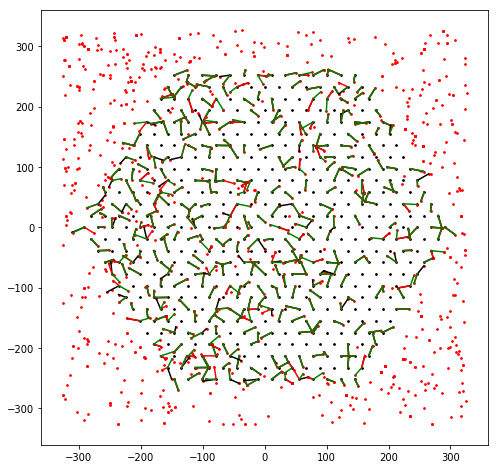

In [18]:
f = observesim.field.Field(racen=racen, deccen=deccen)
f.read_cadences('cadences-1.fits')
f.read_targets('targets-1.fits')
f.field_cadence = 2
f.assign()
f.plot()

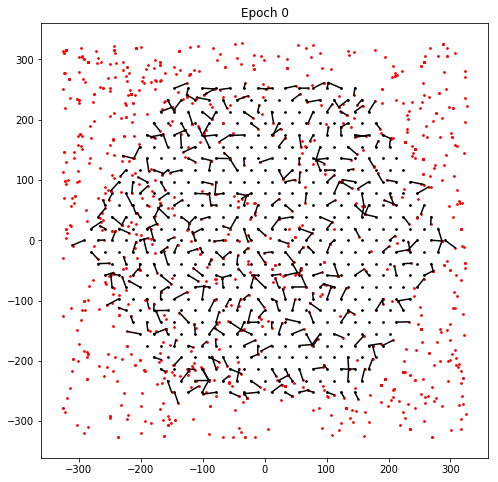

In [19]:
epoch = 0
f.plot(epochs=epoch)
plt.title('Epoch ' + str(epoch))
plt.savefig('epoch-{epoch}.png'.format(epoch=epoch))

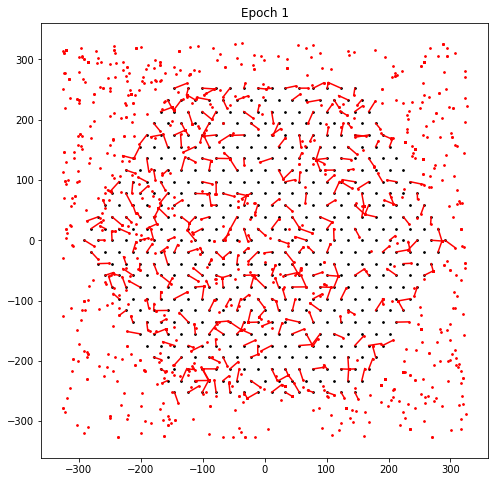

In [20]:
epoch = 1
f.plot(epochs=epoch)
plt.title('Epoch ' + str(epoch))
plt.savefig('epoch-{epoch}.png'.format(epoch=epoch))

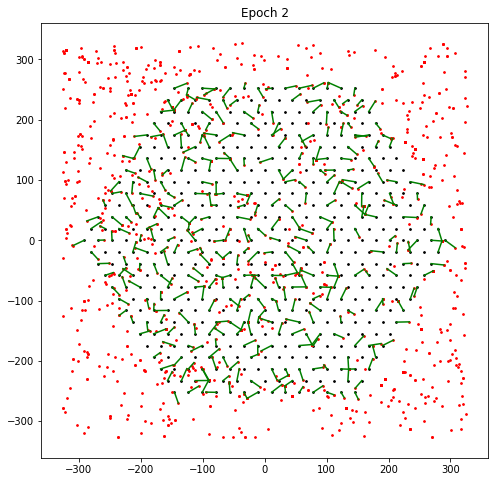

In [21]:
epoch = 2
f.plot(epochs=epoch)
plt.title('Epoch ' + str(epoch))
plt.savefig('epoch-{epoch}.png'.format(epoch=epoch))

There need to be a lot more tests that this is doing what we expect, but at least it runs!